# How far can I reduce the feature of Auto-encoder
previously done some, but this script focused on it.

Test different activation

In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

import fastcluster as fc

CPU times: user 1.19 s, sys: 366 ms, total: 1.56 s
Wall time: 2.61 s


# Autoencoder 32 - encoder features 32x16

In [40]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 32, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), z
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32, 8])
torch.Size([32])
torch.Size([32, 32,

# Autoencoder 16 encoder features 16x16

In [57]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=8, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl21 = nn.MaxPool1d(2, stride=4)
        self.cv22 = nn.Conv1d(32, 16, kernel_size=8, stride=4, padding=4)
        self.pl22 = nn.MaxPool1d(2, stride=4)
                
        self.ct1 = nn.ConvTranspose1d(16, 32, kernel_size=8, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=8, stride=4, padding=2)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=8, stride=4,padding=2)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        return self.pl21(self.cv21(h1)), self.pl22(self.cv22(h1))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), z
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl21): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(32, 16, kernel_size=(8,), stride=(4,), padding=(4,))
  (pl22): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(16, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(8,), stride=(4,), padding=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(8,), stride=(4,), padding=(2,))
)
torch.Size([32, 1, 8])
torch.Size([32])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([16])
torch.Size([16, 32, 8])
torch.Size([32])
torch.Size([32, 32,

# Autoencoder 8 encoder features 8x17

In [63]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=2, stride=4, padding=0)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv2 = nn.Conv1d(32, 32, kernel_size=2, stride=2, padding=0)
        self.pl2 = nn.MaxPool1d(2, stride=2)
        
        self.cv31 = nn.Conv1d(32, 8, kernel_size=2, stride=2, padding=2)
        self.pl31 = nn.MaxPool1d(2, stride=2)
        self.cv32 = nn.Conv1d(32, 8, kernel_size=2, stride=2, padding=2)
        self.pl32 = nn.MaxPool1d(2, stride=2)
        
        self.ct1 = nn.ConvTranspose1d(8, 32, kernel_size=2, stride=4, padding=1)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=2, stride=2, padding=0)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 32, kernel_size=2, stride=2,padding=0)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=2, stride=2,padding=0)


    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        h1 = F.tanh(self.pl2(self.cv2(h1)))
        return F.tanh(self.pl31(self.cv31(h1))), F.tanh(self.pl32(self.cv32(h1)))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        h3 = F.leaky_relu(self.ct3(h3))
        h3 = self.up3(h3)
        return F.leaky_relu(self.ct4(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), z
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(2,), stride=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv1d(32, 32, kernel_size=(2,), stride=(2,))
  (pl2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv31): Conv1d(32, 8, kernel_size=(2,), stride=(2,), padding=(2,))
  (pl31): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv32): Conv1d(32, 8, kernel_size=(2,), stride=(2,), padding=(2,))
  (pl32): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(8, 32, kernel_size=(2,), stride=(4,), padding=(1,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(2,), stride=(2,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 32, kernel_size=(2,), stride=(2,))
  (up3): Upsample(scale_factor=2, mode=nearest)
  (ct4): ConvTranspose1d(32, 1, kernel_si

# Autoencoder 8, encoder features 8x12 kernel size small

In [8]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 32, kernel_size=16, stride=4, padding=0)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv2 = nn.Conv1d(32, 32, kernel_size=16, stride=2, padding=0)
        self.pl2 = nn.MaxPool1d(2, stride=2)
        
        self.cv31 = nn.Conv1d(32, 8, kernel_size=16, stride=2, padding=2)
        self.pl31 = nn.MaxPool1d(2, stride=2)
#         self.cv32 = nn.Conv1d(32, 8, kernel_size=2, stride=2, padding=2)
#         self.pl32 = nn.MaxPool1d(2, stride=2)
        
        self.ct1 = nn.ConvTranspose1d(8, 32, kernel_size=16, stride=4, padding=0)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=16, stride=2, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 32, kernel_size=16, stride=2,padding=0)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=16, stride=2,padding=3)


    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.leaky_relu(self.pl1(self.cv1(x)))
        h1 = F.leaky_relu(self.pl2(self.cv2(h1)))
        return F.leaky_relu(self.pl31(self.cv31(h1)))

    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        h3 = F.leaky_relu(self.ct3(h3))
        h3 = self.up3(h3)
        return F.leaky_relu(self.ct4(h3))
    
    def forward(self,inputs):
        mu = self.encoder(inputs)
#         z = self.reparameterise(mu, logvar)
        return self.decoder(mu), mu
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 32, kernel_size=(32,), stride=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv1d(32, 32, kernel_size=(32,), stride=(2,))
  (pl2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv31): Conv1d(32, 8, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl31): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(8, 32, kernel_size=(32,), stride=(4,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(32,), stride=(2,), padding=(1,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 32, kernel_size=(32,), stride=(2,))
  (up3): Upsample(scale_factor=2, mode=nearest)
  (ct4): ConvTranspose1d(32, 1, kernel_size=(32,), stride=(2,), padding=(3,))
)
torch.Size([32, 1, 32])
torch.Size([32])
torch.Size([32, 32, 32])
torch.Size([32])
torch.Size([8, 32, 32])
to

# Auto-encoder deep split 8x7

In [40]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 128, kernel_size=32, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(128, 64, kernel_size=32, stride=2, padding=2)
        self.pl21 = nn.MaxPool1d(2, stride=2)
        self.cv22 = nn.Conv1d(128, 64, kernel_size=32, stride=2, padding=2)
        self.pl22 = nn.MaxPool1d(2, stride=2)
       
        self.cv31 = nn.Conv1d(64, 8, kernel_size=32, stride=2, padding=2)
        self.pl31 = nn.MaxPool1d(2, stride=2)
        self.cv32 = nn.Conv1d(64, 8, kernel_size=32, stride=2, padding=2)
        self.pl32 = nn.MaxPool1d(2, stride=2)
        
        self.ct1 = nn.ConvTranspose1d(8, 64, kernel_size=32, stride=4, padding=0)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(64, 64, kernel_size=32, stride=2, padding=3)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(64, 32, kernel_size=32, stride=2,padding=2)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=32, stride=2,padding=3)


    def encoder(self, x):
#         h0 = self.norm(x)
        h0 = F.leaky_relu(self.pl1(self.cv1(x)))
        h1 = F.leaky_relu(self.pl21(self.cv21(h0)))
        h2 = F.leaky_relu(self.pl22(self.cv22(h0)))
        return F.leaky_relu(self.pl31(self.cv31(h1))), F.leaky_relu(self.pl32(self.cv32(h2)))

    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        h3 = F.leaky_relu(self.ct3(h3))
        h3 = self.up3(h3)
        return F.leaky_relu(self.ct4(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), z
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 128, kernel_size=(32,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(128, 64, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl21): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(128, 64, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl22): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv31): Conv1d(64, 8, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl31): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv32): Conv1d(64, 8, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl32): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(8, 64, kernel_size=(32,), stride=(4,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(64, 64, kernel_size=(32,), stride=(2,), padding=(3,))
  (up2

# Auto-encoder large kernel smaller filters

In [2]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 64, kernel_size=32, stride=4, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=4)
        self.cv21 = nn.Conv1d(64, 32, kernel_size=32, stride=2, padding=2)
        self.pl21 = nn.MaxPool1d(2, stride=2)
        self.cv22 = nn.Conv1d(64, 32, kernel_size=32, stride=2, padding=2)
        self.pl22 = nn.MaxPool1d(2, stride=2)
       
        self.cv31 = nn.Conv1d(32, 8, kernel_size=32, stride=2, padding=2)
        self.pl31 = nn.MaxPool1d(2, stride=2)
        self.cv32 = nn.Conv1d(32, 8, kernel_size=32, stride=2, padding=2)
        self.pl32 = nn.MaxPool1d(2, stride=2)
        
        self.ct1 = nn.ConvTranspose1d(8, 64, kernel_size=32, stride=4, padding=0)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(64, 32, kernel_size=32, stride=2, padding=3)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 32, kernel_size=32, stride=2,padding=2)
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct4 = nn.ConvTranspose1d(32, 1, kernel_size=32, stride=2,padding=3)


    def encoder(self, x):
#         h0 = self.norm(x)
        h0 = F.leaky_relu(self.pl1(self.cv1(x)))
        h1 = F.leaky_relu(self.pl21(self.cv21(h0)))
        h2 = F.leaky_relu(self.pl22(self.cv22(h0)))
        return F.leaky_relu(self.pl31(self.cv31(h1))), F.leaky_relu(self.pl32(self.cv32(h2)))

    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        h3 = F.leaky_relu(self.ct3(h3))
        h3 = self.up3(h3)
        return F.leaky_relu(self.ct4(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), z
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 64, kernel_size=(32,), stride=(4,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=4, padding=0, dilation=1, ceil_mode=False)
  (cv21): Conv1d(64, 32, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl21): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv22): Conv1d(64, 32, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl22): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv31): Conv1d(32, 8, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl31): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv32): Conv1d(32, 8, kernel_size=(32,), stride=(2,), padding=(2,))
  (pl32): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(8, 64, kernel_size=(32,), stride=(4,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(64, 32, kernel_size=(32,), stride=(2,), padding=(3,))
  (up2): 

In [3]:
TEST = GEN(Variable(torch.randn(100,1,4096)))
# DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())
# print(DATA.size())
# print(TEST[2].size())

torch.Size([100, 1, 4096])
torch.Size([100, 8, 7])


# Testing Autoencoder

In [4]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

In [6]:
train_loader = DataLoader(dataset=np.load("../train.npy"),
                         batch_size=1000,
                         shuffle=True,
                         num_workers=3)

n_batches = 120

In [7]:
%%time
N_EPOCHS = 5
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, waveform in enumerate(train_loader):
            
#             print("epoch=",epoch)
#             print(batch_number)
#             print(waveform.size(),label.size())
    
            batch_size = waveform.size()[0]
            training_data = waveform.view(batch_size,1,4096)
            target = training_data
            
#             print(training_data,target)
            
            outputs = GEN(training_data)
#             print(outputs, target.view(-1).long())
            
#             print(outputs[0].size())
#             print(training_data.size())
            loss = criterion(outputs[0], target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


#             print(loss.data[0])
        
            if (batch_number +1)%10 == 0:
                print("Epoch[%d/%d], Step[%d/%d], loss=%.6f"
                      %(epoch+1,
                        N_EPOCHS,
                        batch_number+1,
                        n_batches,
                        loss.data[0] ))
            
#             print(GEN.state_dict())
#             torch.save(GEN.state_dict(), "GEN_%d_%d.pkl"%(epoch,N_EPOCHS))
#             print(GEN.encoder(training_data)[0].size())
except KeyboardInterrupt:
    print('Training ended early.')
    
torch.save(GEN.state_dict(),"test_8_7_smaller.pkl")




/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:38: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[1/5], Step[10/120], loss=0.008556
Epoch[1/5], Step[20/120], loss=0.008230
Epoch[1/5], Step[30/120], loss=0.008075
Epoch[1/5], Step[40/120], loss=0.007937
Epoch[1/5], Step[50/120], loss=0.007666
Epoch[1/5], Step[60/120], loss=0.007633
Epoch[1/5], Step[70/120], loss=0.007585
Epoch[1/5], Step[80/120], loss=0.007344
Epoch[1/5], Step[90/120], loss=0.006939
Epoch[1/5], Step[100/120], loss=0.006306
Epoch[1/5], Step[110/120], loss=0.005665
Epoch[1/5], Step[120/120], loss=0.005441
Epoch[2/5], Step[10/120], loss=0.005387
Epoch[2/5], Step[20/120], loss=0.005138
Epoch[2/5], Step[30/120], loss=0.005011
Epoch[2/5], Step[40/120], loss=0.005104
Epoch[2/5], Step[50/120], loss=0.005283
Epoch[2/5], Step[60/120], loss=0.004950
Epoch[2/5], Step[70/120], loss=0.004951
Epoch[2/5], Step[80/120], loss=0.004892
Epoch[2/5], Step[90/120], loss=0.005051
Epoch[2/5], Step[100/120], loss=0.004871
Epoch[2/5], Step[110/120], loss=0.005126
Epoch[2/5], Step[120/120], loss=0.004929
Epoch[3/5], Step[10/120], loss=0.0

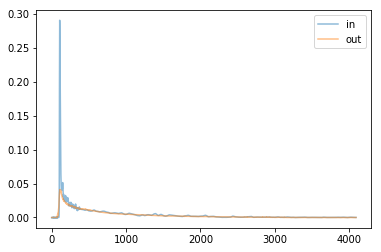

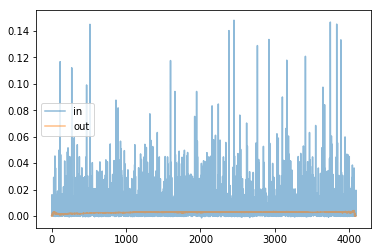

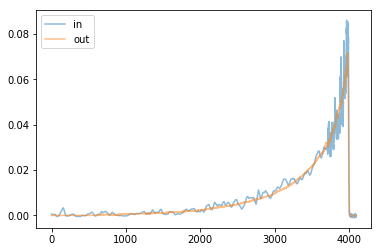

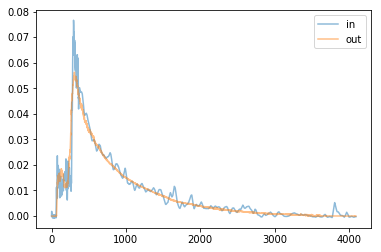

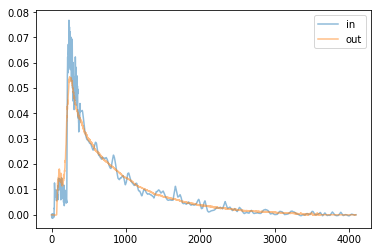

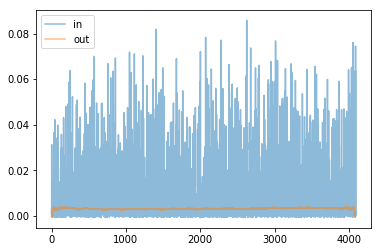

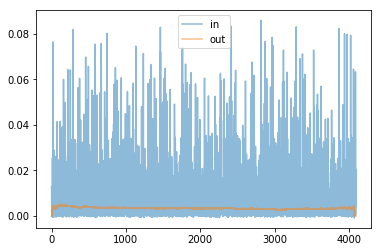

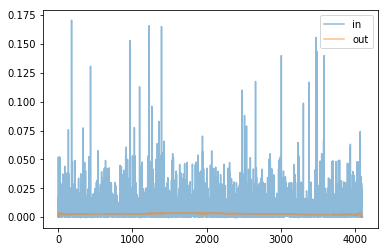

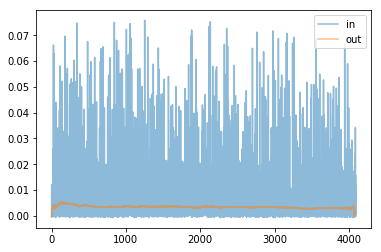

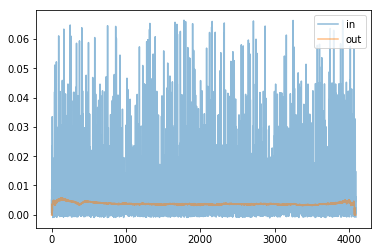

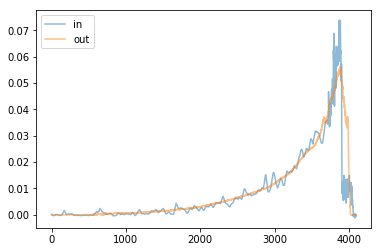

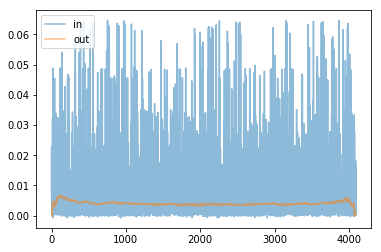

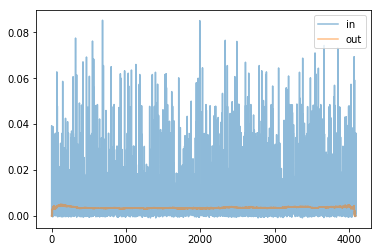

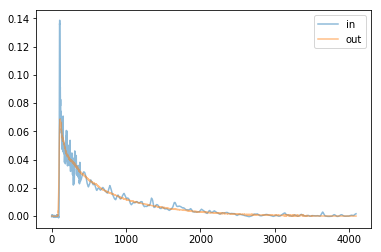

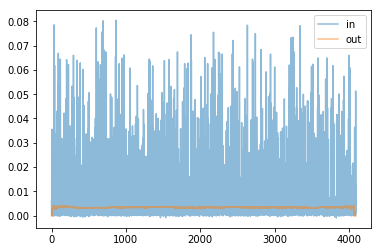

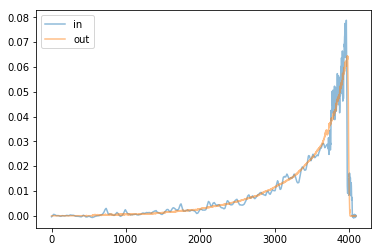

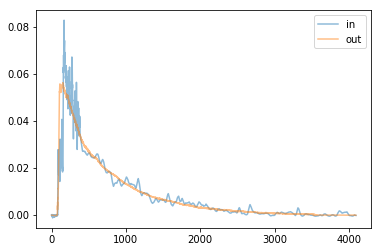

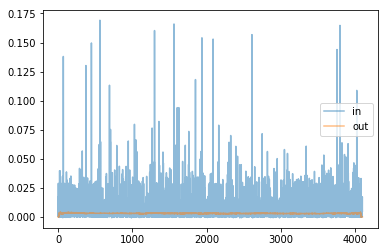

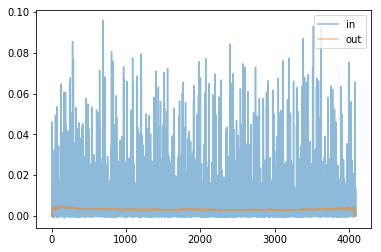

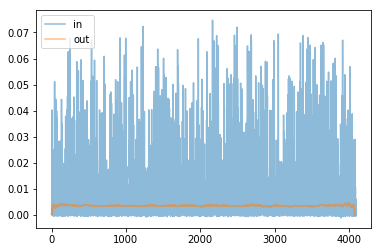

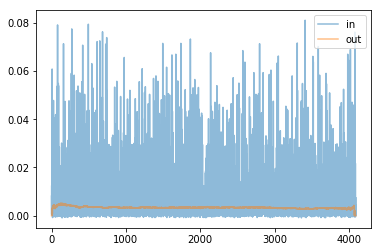

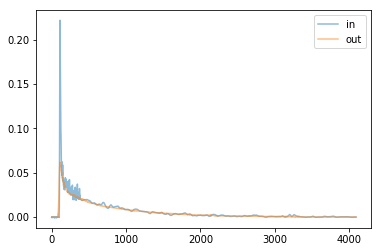

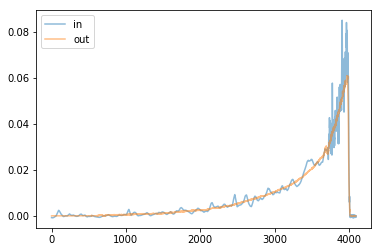

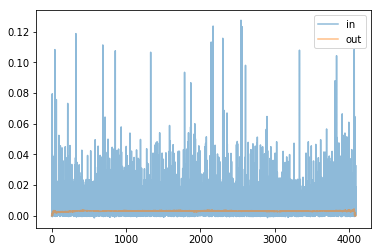

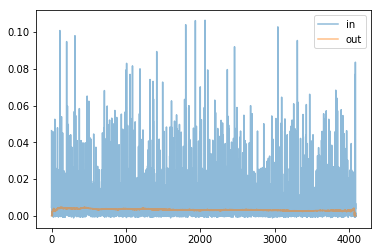

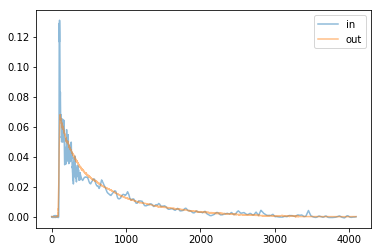

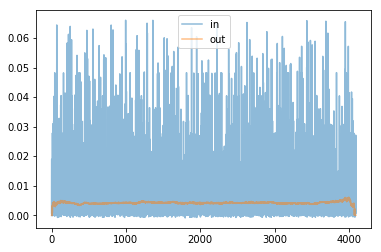

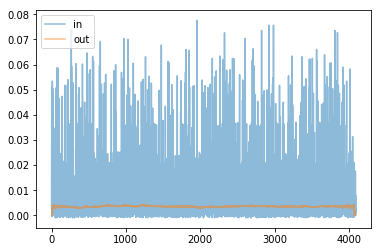

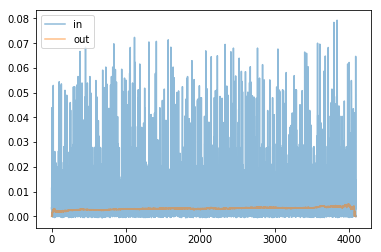

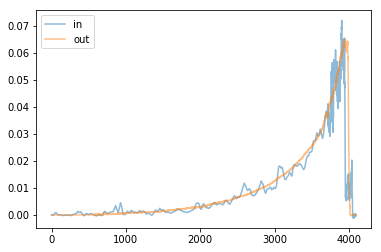

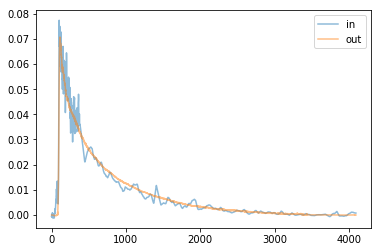

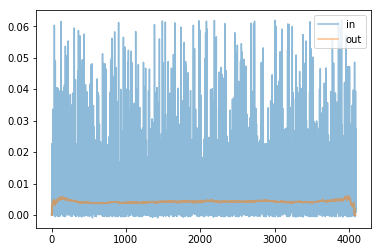

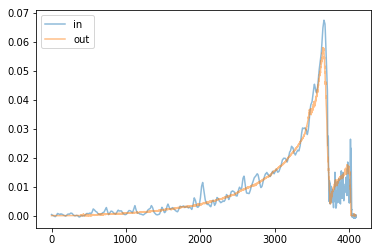

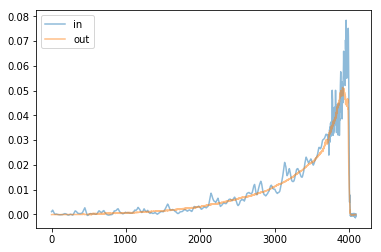

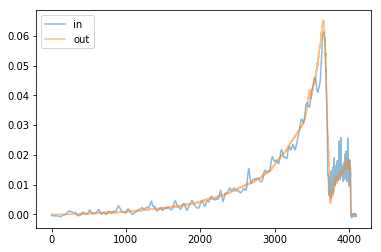

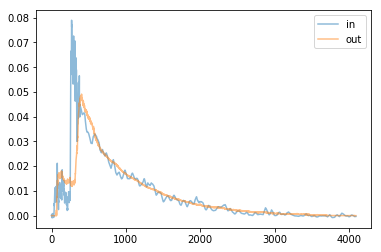

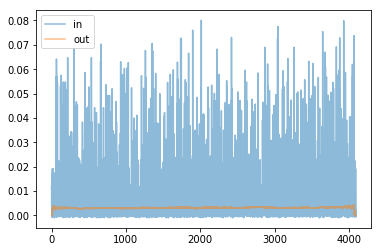

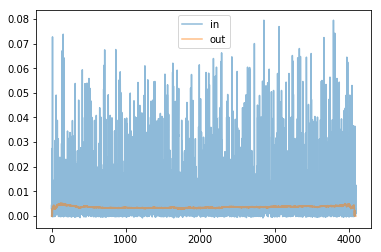

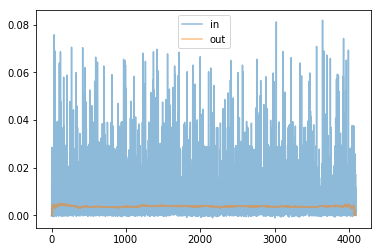

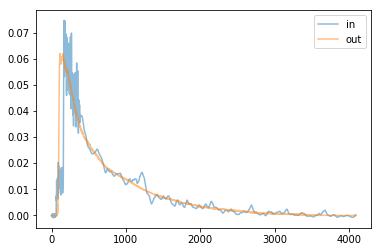

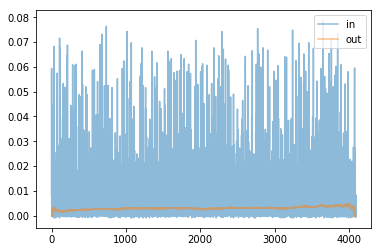

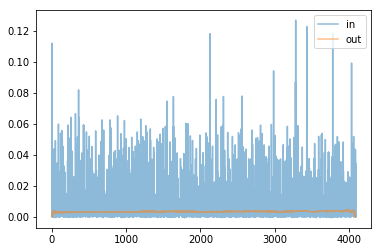

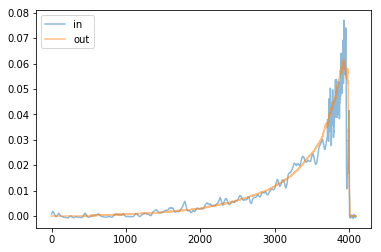

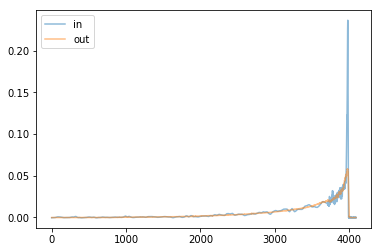

Process Process-16:
Process Process-18:
Process Process-17:


Training ended early.


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **

In [8]:
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, waveform in enumerate(train_loader):
            batch_size = waveform.size()[0]
            training_data = waveform.view(batch_size,1,4096)
            waveform = waveform.detach().numpy()
            outputs = GEN(training_data)
            
            del training_data
            out_w = outputs[0].detach().numpy()
            
            del outputs
            
            for i,j in enumerate(waveform):
                plt.figure(figsize=(6,4))
                plt.plot(j, label="in",alpha=0.5)
                plt.plot(out_w[i][0], label="out",alpha=0.5)
                plt.legend()
                plt.show()
                
except KeyboardInterrupt:
    print('Training ended early.')